<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Applied-Modeling/blob/master/module3/Unit_2_Sprint_3_Module_3_IN_LESSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Applied Modeling, Module 3

- Visualize and interpret **partial dependence plots**

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)


* [Student Project Example: Movie Budgets](http://movie-money.herokuapp.com/)
* [Quiz](https://forms.gle/gEZBvkW3Bq66xwmw8)

# Objectives for Sprint Challenge


## 1)  Pre-Processing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.
How do you deal with leakage?

## 2)  Modeling

Fit a model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and estimate your ROC AUC validation score. 

## 3)  Visualization
Make visualizations for model interpretation, including some or all of these:

- Permutation Importances
- Partial Dependence Plot
- Shapley Values





### Three types of model explanations this unit:

#### 1. Global model explanation: all features in relation to each other _(Last Week)_
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target _(Today)_
- Partial Dependence plots

#### 3. Individual prediction explanation _(Wednesday)_
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).


In [129]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

## Lending Club: Predict interest rate

In [0]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history_location = '../data/lending-club/lending-club-subset.csv'
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate',
           'dti']

history = history[columns]
history = history.dropna()

# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

In [0]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

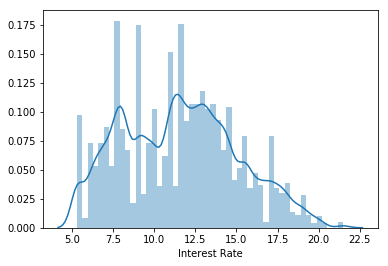

In [133]:
# The target has some right skew, but it's not too bad
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

### Fit Linear Regression model

In [134]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OrdinalEncoder(), # Not ideal for Linear Regression 
    StandardScaler(), 
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.22962655995566986


### Fit Gradient Boosting model

In [135]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.2759763759174477


### Explaining Linear Regression

In [136]:
example = X_val.iloc[[0]]
example

,Annual Income,Credit Score,Loan Amount,Loan Purpose,Monthly Debts,dti
issue_d,,,,,,
2016-12-01,68700.0,729.0,7150.0,Credit card refinancing,1452.4325,25.37


In [137]:
pred = lr.predict(example)[0]
print(f'Predicted Interest Rate: {pred:.2f}%')

Predicted Interest Rate: 10.17%


In [138]:
import numpy as np

def vary_income(model, example):
    print('Vary income, hold other features constant', '\n')
    example = example.copy()
    preds = []
    for income in range(20000, 200000, 20000):
        example['Annual Income'] = income
        pred = model.predict(example)[0]
        print(f'Predicted Interest Rate: {pred:.3f}%')
        print(example.to_string(), '\n')
        preds.append(pred)
    print('Difference between predictions')
    print(np.diff(preds))
        
vary_income(lr, example)

Vary income, hold other features constant 

Predicted Interest Rate: 10.201%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325  25.37 

Predicted Interest Rate: 10.186%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325  25.37 

Predicted Interest Rate: 10.172%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          60000         729.0       7150.0 

In [139]:
example2 = X_val.iloc[[2]]
vary_income(lr, example2)

Vary income, hold other features constant 

Predicted Interest Rate: 13.101%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333  34.93 

Predicted Interest Rate: 13.086%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333  34.93 

Predicted Interest Rate: 13.072%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          60000         684.0       9900.0 

### Explaining Gradient Boosting???

In [140]:
vary_income(gb, example)

Vary income, hold other features constant 

Predicted Interest Rate: 10.263%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325  25.37 

Predicted Interest Rate: 8.898%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325  25.37 

Predicted Interest Rate: 8.337%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          60000         729.0       7150.0  C

In [141]:
vary_income(gb, example2)

Vary income, hold other features constant 

Predicted Interest Rate: 13.898%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333  34.93 

Predicted Interest Rate: 12.578%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333  34.93 

Predicted Interest Rate: 11.969%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts    dti
issue_d                                                                                            
2016-12-01          60000         684.0       9900.0 

## Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

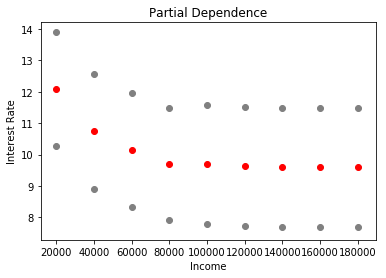

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt

examples = pd.concat([example, example2])
for income in range(20000, 200000, 20000):
    examples['Annual Income'] = income
    preds = gb.predict(examples)
    for pred in preds:
        plt.scatter(income, pred, color='grey')
    plt.scatter(income, np.mean(preds), color='red')
    plt.title('Partial Dependence')
    plt.xlabel('Income')
    plt.ylabel('Interest Rate')

## Partial Dependence Plots with 1 feature

#### PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [144]:
X_val.head()

,Annual Income,Credit Score,Loan Amount,Loan Purpose,Monthly Debts,dti
issue_d,,,,,,
2016-12-01,68700.0,729.0,7150.0,Credit card refinancing,1452.432500,25.37
2016-12-01,70000.0,684.0,12000.0,Business,621.833333,10.66
2016-12-01,55000.0,684.0,9900.0,Credit card refinancing,1600.958333,34.93
2016-12-01,105000.0,709.0,25000.0,Debt consolidation,1591.625000,18.19
2016-12-01,89000.0,669.0,35000.0,Debt consolidation,1022.016667,13.78


In [145]:
X_val.columns

Index(['Annual Income', 'Credit Score', 'Loan Amount', 'Loan Purpose',
       'Monthly Debts', 'dti'],
      dtype='object')

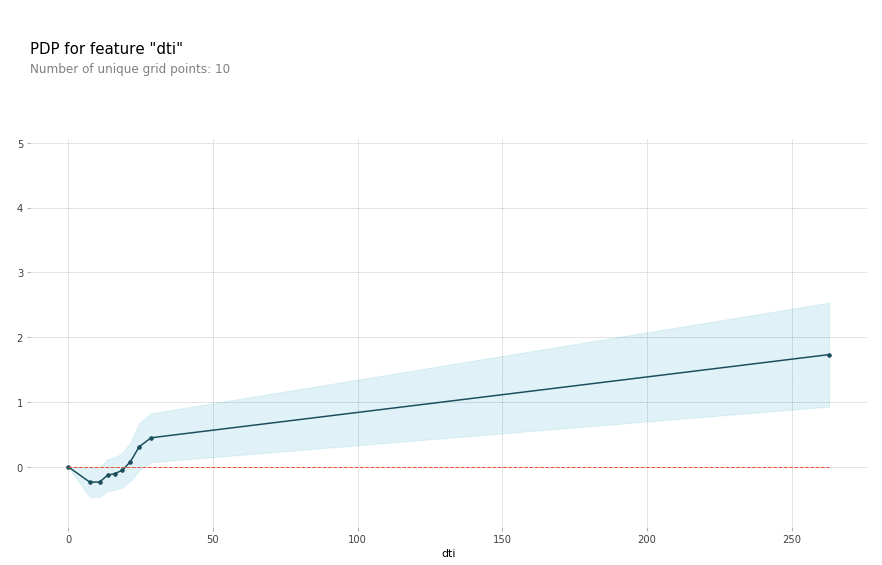

In [172]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'dti'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

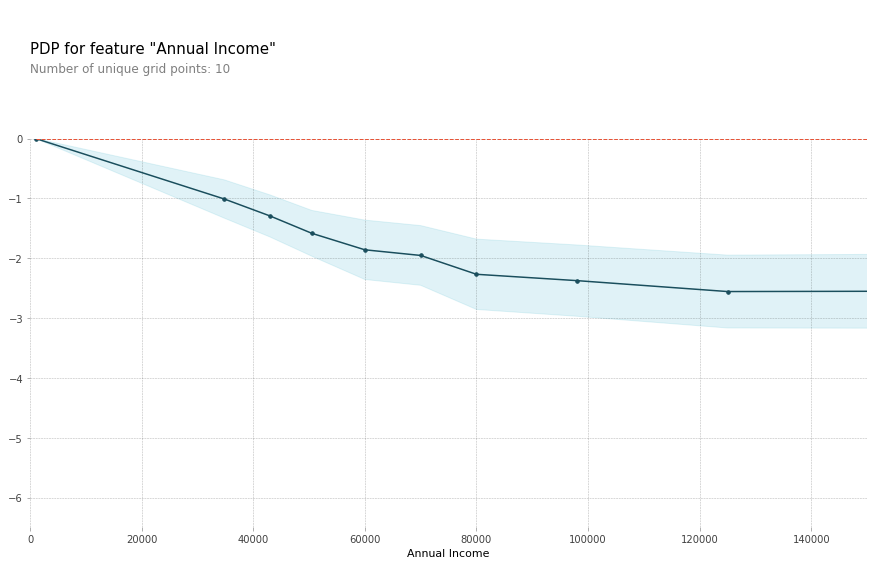

In [147]:
pdp_plot(isolated, feature_name=feature)
plt.xlim(0,150000);

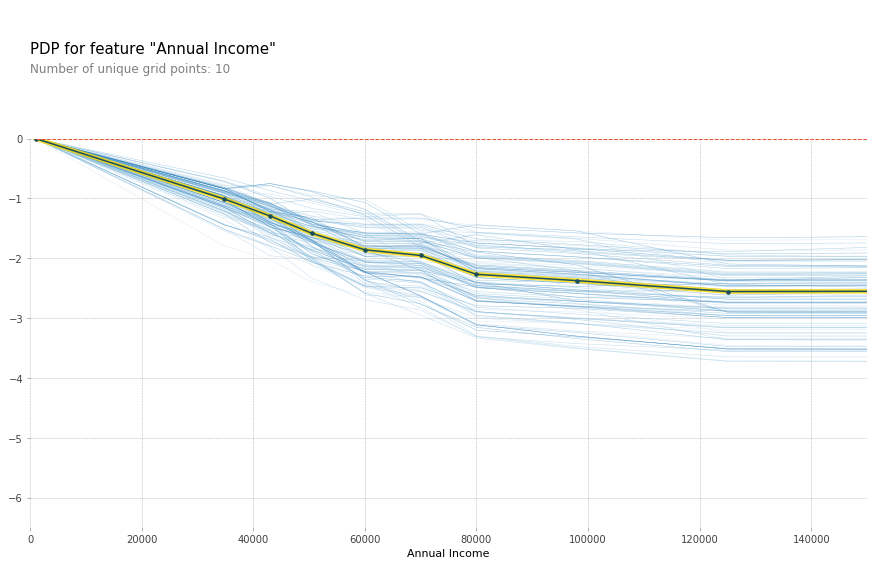

In [148]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,150000);

In [149]:
len(X_val) * 10

100000

In [0]:
isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=80
)


In [151]:
len(X_val) * 80

800000

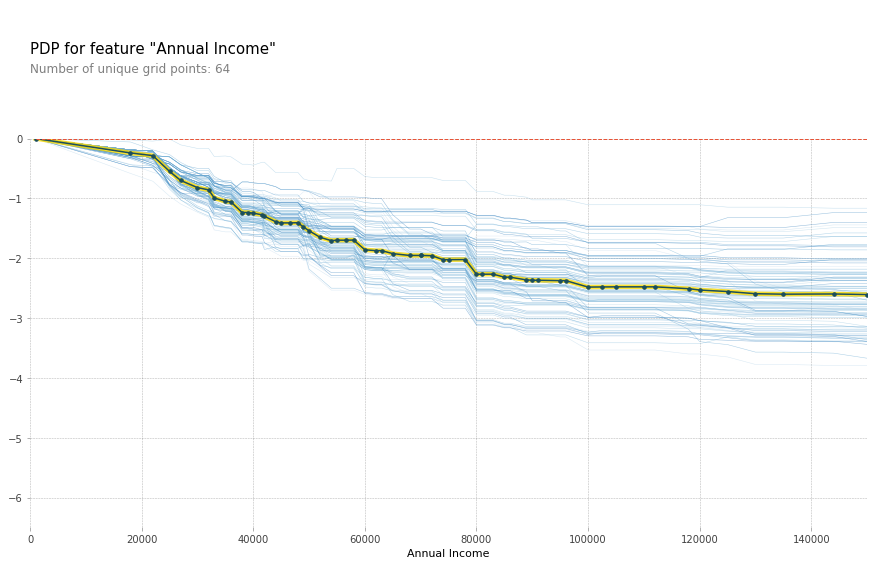

In [152]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,150000);

#### You can customize it

PDPbox
- [API Reference: PDPIsolate](https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html)

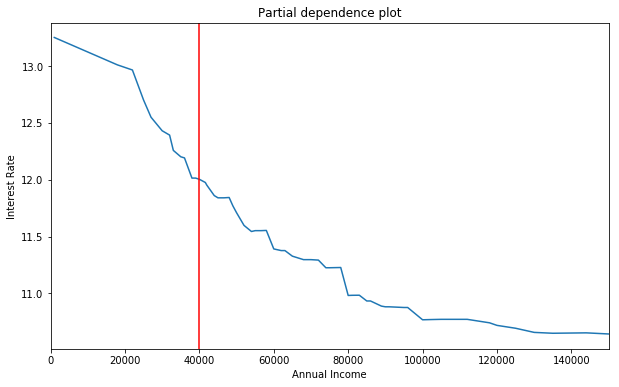

In [153]:
grid = isolated.feature_grids
pdp = isolated.pdp

plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.ylabel('Interest Rate')
plt.xlabel('Annual Income')
plt.title('Partial dependence plot')
plt.xlim(0,150000)
plt.axvline(40000,color='r')
plt.show();

In [154]:
ice = isolated.ice_lines.sample(n=100).T

ice

,3235,518,2306,9779,7120,7843,3445,1471,993,5320,6612,6666,8383,4343,6139,4838,8271,3778,5313,1321,1513,7645,7799,5930,9975,6664,9050,7461,2374,9966,7217,9380,7263,2658,1389,8394,8535,6538,3373,4399,...,3662,826,8115,3039,3840,6750,2932,9807,1516,4219,9126,3035,4347,246,2892,9757,9118,3851,5430,4495,5025,5206,125,6551,4344,3185,7023,9100,1343,3650,498,3438,3836,2762,3168,2864,7913,4031,8706,3532
1000.000000,15.220913,10.412799,9.494713,11.760167,12.856627,14.132299,12.442720,8.450336,10.171751,13.597866,14.293222,12.111452,14.334640,13.785018,12.811345,13.278663,14.659324,13.103101,13.486611,10.158257,12.423244,14.297909,9.426977,10.795080,15.107742,15.781014,15.372844,11.114146,11.107468,14.629458,11.540442,10.137117,9.886312,12.257694,13.655547,13.285198,13.656622,11.418829,9.979627,14.532821,...,12.500582,12.835771,10.403699,12.229411,16.007248,13.838893,14.349627,14.420955,15.585986,11.820876,12.084368,15.466873,13.211235,13.597794,13.838893,15.972498,14.326888,13.651779,14.703627,14.309703,13.815447,13.109474,13.882867,15.241290,12.804293,15.086540,15.017760,12.757182,9.971659,13.105485,13.089212,13.788731,11.614470,13.748892,13.602203,14.567749,16.601854,9.728265,11.033658,12.744979
17963.848101,15.030691,10.096947,9.024733,11.421674,12.666406,13.942078,12.151637,8.111843,9.956760,13.382875,14.078232,11.795600,13.752370,13.570027,12.621123,13.063672,14.444333,12.787249,13.296390,9.663508,12.233022,14.082918,9.088484,10.300331,14.823821,15.590793,15.182622,10.798294,10.536626,14.345537,11.325452,9.798624,9.696090,12.042704,13.339695,12.994115,13.372701,11.127746,9.688543,14.317830,...,12.310360,12.544687,10.213477,12.171816,15.817025,13.623902,14.292031,14.230733,15.395764,11.630654,11.768516,15.276651,12.996244,13.382803,13.623902,15.681415,14.136666,13.461557,14.513405,14.119481,13.625225,12.919252,13.667876,15.183695,12.589302,14.896318,14.802770,12.466099,9.756668,12.814402,12.874222,13.598509,11.399480,13.533901,13.286351,14.510154,16.411633,9.258285,10.670396,12.453896
22000.000000,15.011093,9.965398,9.005135,11.402076,12.646808,13.922480,12.132039,8.092245,9.887972,13.314087,13.946683,11.726811,13.620821,13.501239,12.601525,12.994884,14.312784,12.718460,13.276792,9.531960,12.213424,13.951369,9.068886,10.168782,14.692272,15.571195,15.163024,10.729506,10.517028,14.213988,11.256663,9.779026,9.676492,11.911155,13.208146,12.974517,13.241152,11.108148,9.668945,14.249042,...,12.290762,12.525089,10.193879,12.040267,15.797427,13.555114,14.160482,14.211135,15.376166,11.611056,11.699727,15.257053,12.927456,13.251254,13.555114,15.661817,14.117068,13.441959,14.493807,14.099883,13.605627,12.899654,13.648278,15.052146,12.569704,14.876720,14.783172,12.446501,9.687880,12.794804,12.805433,13.578911,11.330691,13.465113,13.154802,14.378605,16.392036,9.238687,10.650798,12.434298
25000.000000,14.703392,9.716379,8.697433,11.101536,12.370089,13.614779,11.654866,7.784541,9.774182,13.290991,13.867135,11.534247,13.371801,13.478143,12.293823,12.971787,14.233234,12.525896,12.969090,9.452411,11.912883,13.871821,8.340117,10.089233,14.612724,15.294477,14.886306,10.446248,10.070838,14.134440,11.233568,9.502306,9.368790,11.831606,12.959126,12.497346,13.161602,10.661959,9.222755,14.225945,...,12.014043,12.078901,9.886176,11.960718,15.520709,13.441324,14.002057,13.903434,15.099448,11.303353,11.507062,14.980335,12.904362,13.171704,13.441324,15.354115,13.816527,13.141420,14.193266,13.823163,13.297924,12.622935,13.340577,14.972596,12.262002,14.600000,14.475471,11.969328,9.574090,12.317633,12.782337,13.278370,11.307595,13.442017,12.905783,14.299057,16.115314,8.938146,10.343096,11.957125
27000.000000,14.530139,9.584249,8.456280,11.034578,12.235233,13.373628,11.477079,7.543391,9.642052,13.158860,13.735004,11.402117,13.239671,13.346012,12.052672,12.839657,14.101104,12.393765,12.791302,9.320280,11.778028,13.739691,8.205263,9.957103,14.489628,15.159620,14.751450,10.314117,9.935983,14.011344,11.101438,9.367451,9.191002,11.699475,12.826996,12.256195,13.029471,1

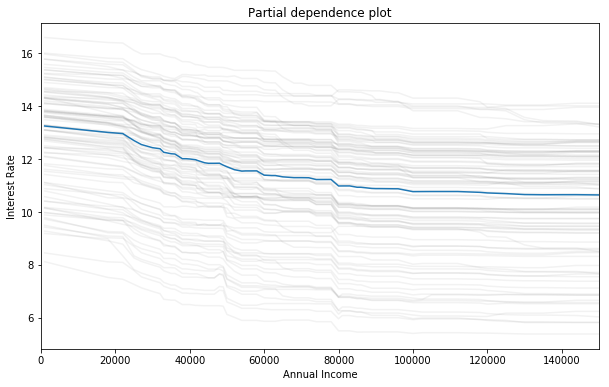

In [155]:
ice.plot(color='grey', alpha=0.1, legend=False, figsize=(10,6))

plt.plot(grid, pdp)
plt.ylabel('Interest Rate')
plt.xlabel('Annual Income')
plt.title('Partial dependence plot')
plt.xlim(0,150000);


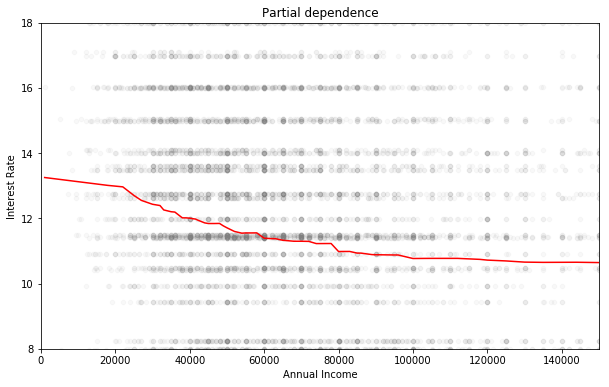

In [156]:
grid = isolated.feature_grids
pdp = isolated.pdp

val.plot.scatter(x='Annual Income', y='Interest Rate', 
                 color='grey', alpha=0.05, figsize=(10,6));

plt.plot(grid, pdp, color='r')
plt.xlim(0,150000)
plt.ylim(8,18)
plt.xlabel('Annual Income')
plt.ylabel('Interest Rate')
plt.title('Partial dependence');

In [0]:
# TODO

## Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

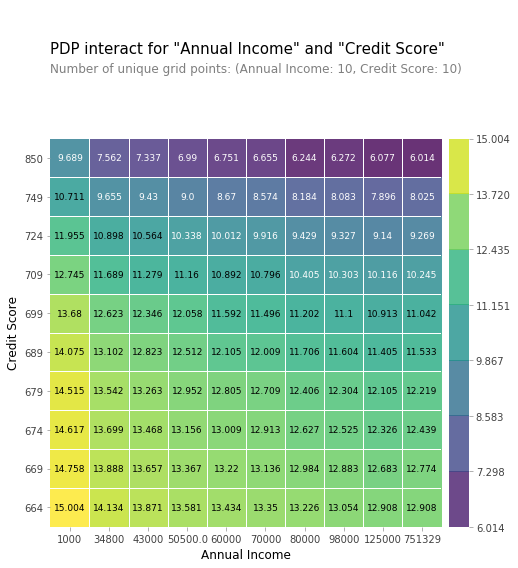

In [158]:
# TODO

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interaction = pdp_interact(
  model=gb,
  dataset=X_val,
  model_features=X_val.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

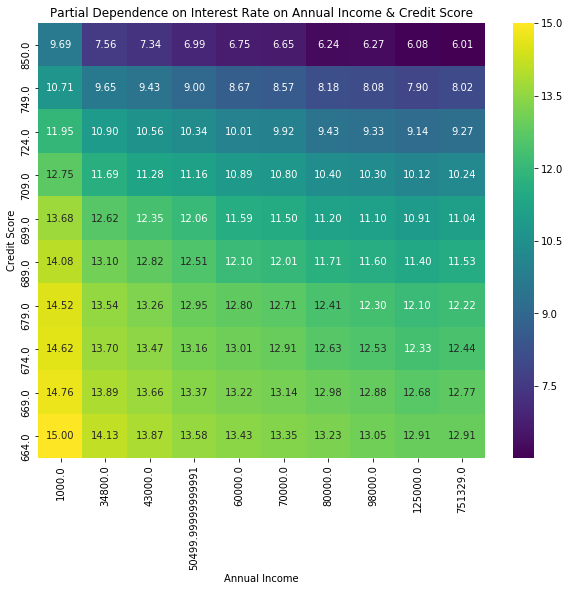

In [159]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence on Interest Rate on Annual Income & Credit Score');




### 3D with Plotly!

In [160]:
import plotly.graph_objs as go

surface = go.Surface(x=pdp.columns, 
                     y=pdp.index, 
                     z=pdp.values)

fig = go.Figure(surface)
fig.show()

In [161]:
pdp.columns

Float64Index([           1000.0,           34800.0,           43000.0,
              50499.99999999991,           60000.0,           70000.0,
                        80000.0,           98000.0,          125000.0,
                       751329.0],
             dtype='float64', name='Annual Income')

In [0]:
pdp = pdp.drop(columns=751329.0)

In [163]:
surface = go.Surface(x=pdp.columns, 
                     y=pdp.index, 
                     z=pdp.values)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

# Partial Dependence Plots with categorical features

1. I recommend you use Ordinal Encoder, outside of a pipeline, to encode your data first. (If there is a natural ordering, then take the time to encode it that way, instead of random integers.) Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.

In [164]:
# Fit a model on Titanic data
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = sns.load_dataset('titanic')
df.age = df.age.fillna(df.age.median())
df = df.drop(columns='deck')
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

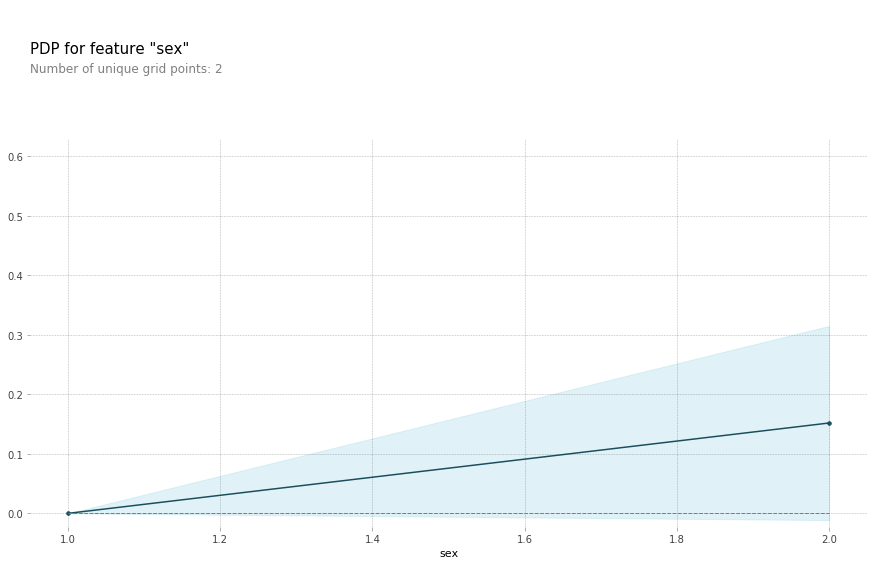

In [165]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [166]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'sex', 'data_type': dtype('O'), 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64},
 {'col': 'embarked', 'data_type': dtype('O'), 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64},
 {'col': 'class',
  'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False),
  'mapping': First     1
  Second    2
  Third     3
  NaN      -2
  dtype: int64},
 {'col': 'who', 'data_type': dtype('O'), 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64},
 {'col': 'embark_town', 'data_type': dtype('O'), 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64}]

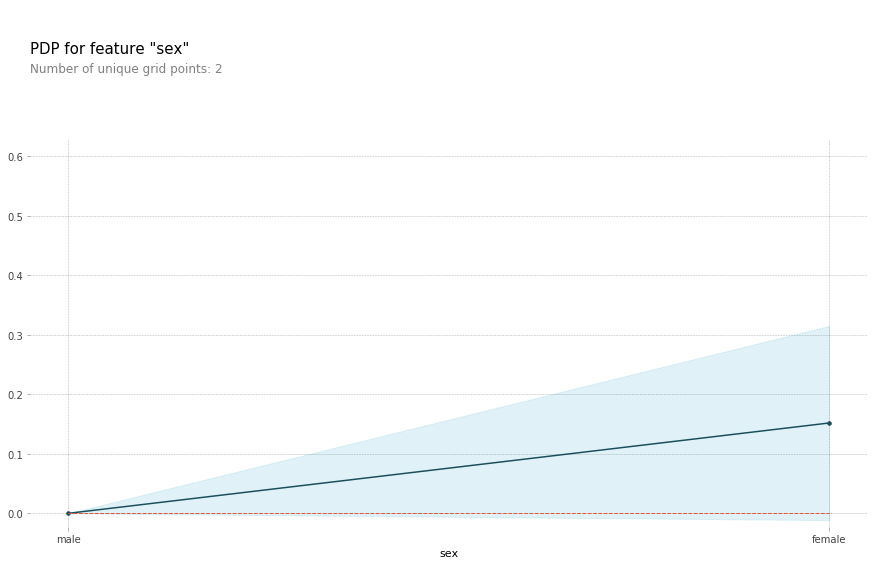

In [167]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([1, 2], ['male', 'female']);

In [0]:
# Let's automate it

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

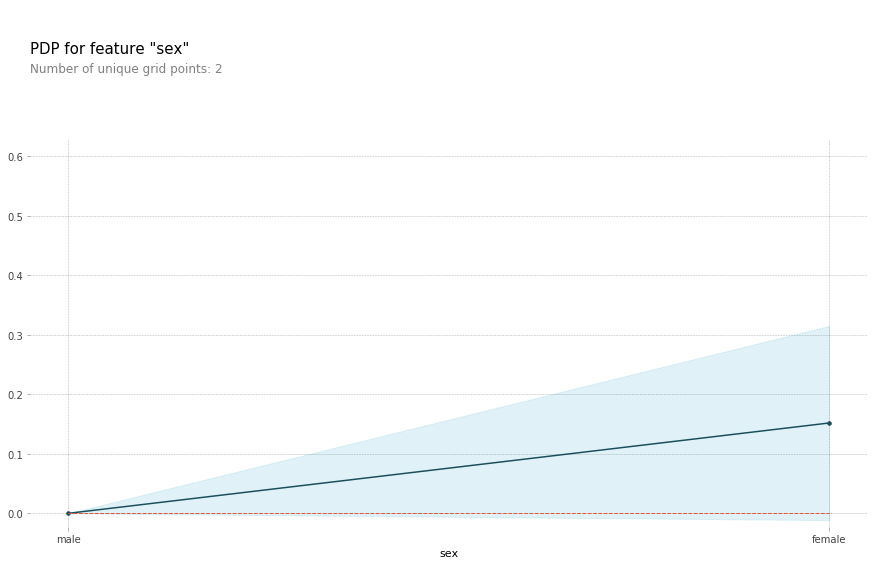

In [169]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

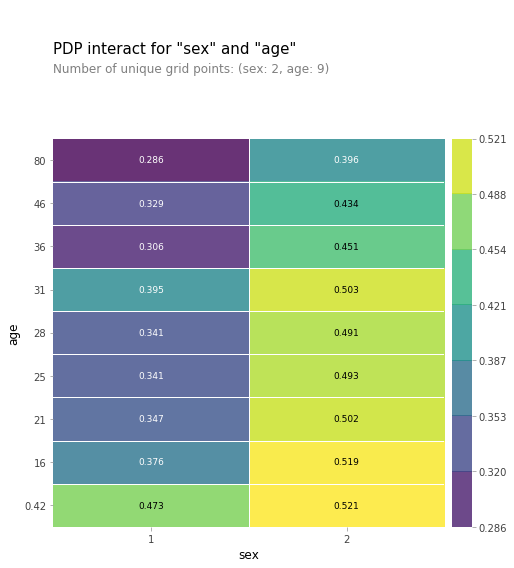

In [170]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

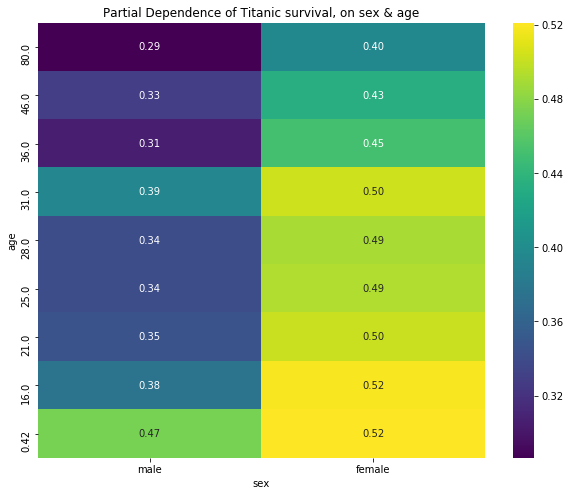

In [171]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Titanic survival, on sex & age');